<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/Single_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Please open this file in Google Colab in order to run this notebook simply and interactively.**

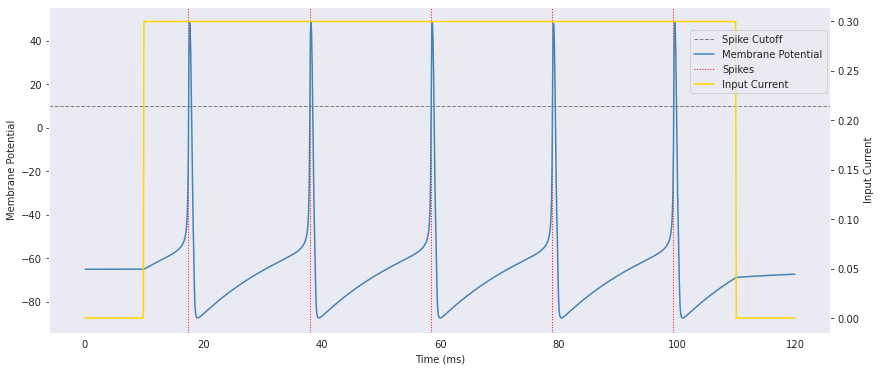

# **Simulating Single Neurons**


---
In this notebook you can interactively examine the spiking and reset behavior of different types of single neurons. We will show the equations for the underlying dynamical systems for the neuron models and implement them using the [brian2 toolbox](https://briansimulator.org) (Stimberg et al., 2019). 

Before we dive in, we need to install some mandatory stuff by executing the cells below.

---

# Preparations

Install required packages and clone the Neuropynamics Repo.

In [1]:
# We use the brian2 toolbox for our models in the backend
!pip install brian2 -q

# clone our repo
!git clone https://github.com/DiGyt/neuropynamics/ -q

     |████████████████████████████████| 1.5 MB 3.2 MB/s 


Import all relevant libraries and functions.

In [2]:
# Main packages
import numpy as np

# Brian2 package
# Unit definitions
from brian2 import mV, ms, volt, second, umetre, ufarad, siemens, cm, msiemens, amp, uA, nA
# Other stuff
from brian2 import start_scope, NeuronGroup, StateMonitor, SpikeMonitor, run

# Plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
from neuropynamics.src.utils.plotting import plot_single_neuron

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout

Configure IPyWidgets (for interactive visualization).

In [3]:
# Allow for larger output cells
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Set button layout
button_layout = Layout(width='180px', height='30px')

# Set slider config
slider_total_width = '800px'
slider_desc_width = '200px'

<IPython.core.display.Javascript object>

# Simulations of single neurons

In the following, we will take a look at some models for single neurons. These are heavily inspired by Devrim Celik's work for interactive neuron simulation (https://github.com/Devrim-Celik/interactive_neuron_model_simulator). However, this notebook is a standalone cloud-based simulator that needs no installation on your system whatsoever.

## Perfect Integrator

To give you a short introduction to the brian2 toolbox, lets take a look at the perfect integrator neuron and how it can be implemented using brian2.

Do not worry if you don't get everything right away, we designed our toolbox in a way that allows you to play around with the simulations without having to write or change a single line of code.

In brian2, every neuron is defined by a set of differential equations. In addition, the threshold for spiking is defined as an equation as well as the reset behavior after spiking.

For the perfect integrator, the equation is quite simple: 

$\dot{v} = \frac{I}{\tau}$ 

where $v$ is the membrane potential, $I$ is the external current and the membrane time constant $\tau$ modulates the charging of the integrator. 

The neuron spikes if the membrane potential $v$ exceeds the threshold $v_{max}$ and then the membrane potential is reset to a value below the threshold (in our case 20mV below that).

Let's take a look at how this looks in our code (also execute this cell, so we can call the function later on):





In [4]:
def create_perfect_integrator_neuron(v_max):
    """Creates a brian2 NeuronGroup that contains a single perfect integrator neuron"""
    # Define differential equation for perfect integrator neuron
    eqs = '''   
        dv/dt = I/tau : volt
        
        I : volt
        '''
    # Define reset function
    reset = 'v = {}*mV'.format(v_max-20)
    # Define threshold
    threshold = 'v > {}*mV'.format(v_max)
    # Return NeuronGroup object
    return NeuronGroup(1, eqs, threshold = threshold, reset = reset, method = 'euler')

As you can see, SI units imported from the brian2 package (see above) are "multiplied" with a variable to denote its unit in these equations. This is the way brian2 integrates units within Python and you will see it a lot throughout this code. The equations also specify the resulting unit for each equation. 

Also, as brian2 is mostly used for modeling of larger-scale models instead of single neurons, we have to create a "NeuronGroup" of one neuron defined by the equations, threshhold, reset behavior, and the method of numerical integration used to solve the equations.

After the creation of a neuron (or technically a group of a single neuron), we can then define the neurons parameters dynamically in the code. For the perfect integrator, $\tau$ regulates the charge of neuron over time. The last line of the code snippet from the cell below sets the value of $\tau$ to the function parameter.

```
def create_and_plot_perfect_integrator_neuron(I_ext, tau, v_max):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_perfect_integrator_neuron(v_max)      
  # Set neuron parameters
  tau = tau*ms;
```

Again, we need to define the unit of our $\tau$ by multiplying it with the unit "ms" imported from brian2. The rest of the code in the function is used to set up monitoring of the neurons state and spiking and injecting a current. Everything outside the function is used for creating an interactive plot to play around with the model.

That's it for the short intro to brian2. You can see the perfect integrator in action by executing the cell below. You may change the external current and tau using the slides and see for yourselves how that influences the neurons behavior. Please be aware that especially for more complex models, the plot might take a bit to update.

For more information about brian2, see the [official tutorials](https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html).

In [5]:
# Function that creates a neuron and plots its behavior based on the given parameters
def create_and_plot_perfect_integrator_neuron(I_ext, tau, v_max):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_perfect_integrator_neuron(v_max)      
  # Set neuron parameters
  tau = tau*ms;
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'I'], record = 0)
  # Start monitoring spiking behavior
  spikemon = SpikeMonitor(source = neuron, variables= 'v')
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Set input current to neuron
  neuron.I = I_ext * mV
  # Run 500ms with input
  run(500*ms)
  # Remove input current to neuron
  neuron.I = 0 * mV
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Plot results
  plot_single_neuron(x = statemon.t/ms, neuron_data = [statemon.v[0]/mV], neuron_labels = ['Membrane Potential'], neuron_colors = ['steelblue'], \
                     spikes = spikemon.t/ms, spike_color = 'red', \
                     input_current = statemon.I[0]/mV, input_label = 'Input Current', input_color = 'gold', \
                     y_range = [-80,-40], title = 'Perfect Integrator Neuron', x_axis_label = 'Time (ms)', y_axis_label = 'Membrane Potential', input_axis_label = 'Input Current', hline = v_max)
  
# Set default parameters 
I_ext_def = 10.
tau_def = 20.

# Create sliders for neuron parameters
tau_slider = widgets.FloatSlider(value = tau_def, min = 1., max = 30., step = 1, description = 'Charging modulation tau:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for input current
I_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 40., step = 1, description = 'Input current I:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(create_and_plot_perfect_integrator_neuron, I_ext = I_slider, tau = tau_slider, v_max = fixed(-50))

def reset_perfect_integrator(name):
  I_ext_slider.value = I_ext_def
  tau_slider.value = tau_def

# Reset button
reset_button = widgets.Button(description='Reset', layout = button_layout)
reset_button.on_click(reset_perfect_integrator)

# Display main widgets and reset button
display(VBox(children=[reset_button, main_widgets]))

## Leaky Integrate-and-Fire Model

Now after having examined our perfect integrator, let's drag it down to reality, where nothing really is perfect (and that is the beauty of it). 

Neurons have channels on their membrane that allow ions to pass through it and therefore they are leaky. In order to reflect this, we just have to alter our equations a bit to amount for the leakage:

$\dot{v} = \frac{E_{leak} - v + I}{\tau}$  

Looking at this through the brian2 code lens, this results in the following:




In [6]:
def create_lif_neuron(v_max):
    """Creates a brian2 NeuronGroup that contains a single leaky integrate-and-fire neuron"""
    # Define differential equation for leaky integrate-and-fire neuron
    eqs = '''   
        dv/dt = ((El - v) + I)/tau : volt
        
        I : volt
        '''
    # Define reset function
    reset = 'v = {}*mV'.format(v_max-20)
    # Define threshold
    threshold = 'v > {}*mV'.format(v_max)
    # Return NeuronGroup object
    return NeuronGroup(1, eqs, threshold = threshold, reset = reset, method = 'euler')

The reset and threshold functions are still the same and we included the changed differential equations that amounts for the leakage. Now we just need to set the leakage "El" in the neuron parameter section and we are good to go.



```
def create_and_plot_lif_neuron(I_ext, tau, e_leak, v_max):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_lif_neuron(v_max)      
  # Set neuron parameters
  tau = tau*ms;
  El = -e_leak*mV
```

Execute the following cell and see how different leakage affects the behavior of our model.

In [7]:
# Create function that creates a neuron and plots its behavior based on the given parameters
def create_and_plot_lif_neuron(I_ext, tau, e_leak, v_max):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_lif_neuron(v_max)      
  # Set neuron parameters
  tau = tau*ms;
  El = -e_leak*mV
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'I'], record = 0)
  # Start monitoring spiking behavior
  spikemon = SpikeMonitor(source = neuron, variables= 'v')
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Set input current to neuron
  neuron.I = I_ext * mV
  # Run 500ms with input
  run(500*ms)
  # Remove input current to neuron
  neuron.I = 0 * mV
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Plot results
  plot_single_neuron(x = statemon.t/ms, neuron_data = [statemon.v[0]/mV], neuron_labels = ['Membrane Potential'], neuron_colors = ['steelblue'], \
                     spikes = spikemon.t/ms, spike_color = 'red', \
                     input_current = statemon.I[0]/mV, input_label = 'Input Current', input_color = 'gold', \
                     y_range = [-90,0], title = 'Leaky Integrate-and-Fire Neuron', x_axis_label = 'Time (ms)', y_axis_label = 'Membrane Potential', input_axis_label = 'Input Current', hline = v_max)
  
# Set default parameters 
I_ext_def = 10.
tau_def = 20.
e_leak_def = 59.

# Create sliders for neuron parameters
tau_slider = widgets.FloatSlider(value = tau_def, min = 1., max = 30., step = 1, description = 'Charging modulation tau:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
e_leak_slider = widgets.FloatSlider(value = e_leak_def, min = 0., max = 85., step = 1, description = 'Leakage E_leak:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 

# Create slider for input current
I_ext_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 40., step = 1, description = 'Input current I:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(create_and_plot_lif_neuron, I_ext = I_ext_slider, tau = tau_slider, e_leak = e_leak_slider, v_max = fixed(-50))

def reset_lif(name):
  I_ext_slider.value = I_ext_def
  tau_slider.value = tau_def
  e_leak_slider.value = e_leak_def

# Reset button
reset_button = widgets.Button(description='Reset', layout = button_layout)
reset_button.on_click(reset_lif)

# Display main widgets and reset button
display(VBox(children=[reset_button, main_widgets]))

## Izhikevich model

Now let's take a look at a model that is a bit more complex as it uses a set of equations rather than one line for the behavior of a neuron: The Izhikevich model (Izhikevich, 2003). 

As you may recall from the lecture, the Izhikevich model is a simplification of the FitzHugh Nagumo model (see later). The equations of the dynamical system are as follows:

$\dot{v} = I + v^2 - u$ with

$\dot{u} = a(bv - u)$

If $v$ exceeds the threshold, then $v$ is reset to $c$ and $u$ is set to $u + d$.

Therefore, we have the two parameters $a$ and $b$ effecting the sub-threshold dynamics and $c$ and $d$ accounting for voltage-gated currents. 

In [8]:
def create_izhikevich_neuron(v_max):
    """Creates a brian2 NeuronGroup that contains a single izhikevich neuron"""
    # Define differential equation for izhikevich neuron
    eqs = '''   
        dv/dt = I + (0.04/ms/mV)*v**2 + (5/ms)*v + 140*mV/ms - u : volt

        du/dt = a*(b*v-u) : volt/second
        
        I : volt/second 
        '''
    # Define reset function
    reset = ''' 
        v = c
        u = u + d
        '''
    # Define threshold
    threshold = 'v > {}*mV'.format(v_max)
    # Return NeuronGroup object
    return NeuronGroup(1, eqs, threshold = threshold, reset = reset, method = 'euler')

As you can see, the brian2 implementation of this neuron looks slightly more complicated. In essence, we still follow the equations that you can find in the lecture but we add some more factors and constants to the equation so that we end up with the following equation:

$\dot{v} = I + 0.04v^2 + 5v + 140 - u$

The rest of the equation in the code is just adjusting units via the imported brian2 units.

Now you are ready to play around with the Izhikevich resonate and fire model. You may also use the buttons to configure the neuron's parameters to predefined neuron types. For example, chattering neurons were found in the visual cortex of adult cats and fire a high-frequency burst of spikes. This is one of the six fundamental classes of firing patterns observed in the neocortex of mammals (Connors & Gutnick, 1990; Gray & McCormick, 1996).

Additional note: When looking at the membrane potential of the Izhikevich neuron in the plot, you might find that a spike occurs even though the potential does not exceed the spiking cutoff. This is due to the clocking speed in the brian2 toolbox. It is set to 0.1ms per default (so the neuron state is evaluated 10000 times per second). It might happen that the membrane potential exceeds the cutoff inbetween these. A spike will still be recorded but the membrane potential curve does not look like it has crossed the cutoff point. You can rest assured that it actually did.


In [9]:
# Create function that creates a neuron and plots its behavior based on the given parameters
def create_and_plot_izhikevich_neuron(I_ext, a, b, c, d, v_max):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_izhikevich_neuron(v_max)      
  # Set neuron parameters
  a = a/ms
  b = b/ms
  c = c * mV 
  d = d * volt/second  
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'u', 'I'], record = 0)
  # Start monitoring spiking behavior
  spikemon = SpikeMonitor(source = neuron, variables= 'v')
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Set input current to neuron
  neuron.I = I_ext * volt / second
  # Run 500ms with input
  run(500*ms)
  # Remove input current to neuron
  neuron.I = 0 * volt / second
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Plot results
  plot_single_neuron(x = statemon.t/ms, neuron_data = [statemon.v[0]/mV, statemon.u[0]], neuron_labels = ['Membrane Potential', 'Recovery variable u'], neuron_colors = ['steelblue', 'mediumseagreen'], \
                     spikes = spikemon.t/ms, spike_color = 'red', \
                     input_current = statemon.I[0], input_label = 'Input Current', input_color = 'gold', \
                     y_range = [-100,40], title = 'Izhikevich Neuron', x_axis_label = 'Time (ms)', y_axis_label = 'Membrane Potential / Recovery Variable', input_axis_label = 'Input Current', hline = v_max)
  
# Set default parameters 
I_ext_def = 10.
a_def = 0.02
b_def = 0.2
c_def = -65.
d_def = 8.
vmax_def = 10.

# Create sliders for neuron parameters
a_slider = widgets.FloatSlider(value = a_def, min = 0., max = 0.15, step = 0.01, description = 'Recovery Time Constant a:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
b_slider = widgets.FloatSlider(value = b_def, min = 0., max = 0.35, step = 0.01, description = 'Dynamic Behavior b:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) # Somehow max = 0.3 does not work
c_slider = widgets.FloatSlider(value = c_def, min = -75., max = -40., step = 1, description = 'Voltage Reset Value c:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
d_slider = widgets.FloatSlider(value = d_def, min = 0., max = 10., step = 1, description = 'Spike Activated Net Current d:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for input current
I_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 40., step = 1, description = 'Input Current I:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(create_and_plot_izhikevich_neuron, I_ext = I_slider, a = a_slider, b = b_slider, c = c_slider, d = d_slider, v_max = fixed(vmax_def))

# Create functions to set specific neuron configurations
def apply_config(I_ext, a, b, c, d):
  I_slider.value = I_ext
  a_slider.value = a
  b_slider.value = b
  c_slider.value = c
  d_slider.value = d

def reset_config(name):
  apply_config(I_ext = I_ext_def, a = a_def, b = b_def, c = c_def, d = d_def)

def apply_intrinsically_bursting_config(name):
  apply_config(I_ext = 12., a = a_def, b = b_def, c = -55, d = 4)

def apply_chattering_config(name):
  apply_config(I_ext = I_ext_def, a = a_def, b = b_def, c = -50, d = 2)

def apply_fast_spiking_config(name):
  apply_config(I_ext = I_ext_def, a = 0.1, b = b_def, c = c_def, d = d_def)

def apply_low_thresh_spiking_config(name):
  apply_config(I_ext = I_ext_def, a = a_def, b = 0.25, c = c_def, d = d_def)

def apply_resonator_config(name):
  apply_config(I_ext = I_ext_def, a = 0.1, b = 0.26, c = c_def, d = d_def)

# Create buttons for specific neuron configurations
# Reset button
regular_spiking_button = widgets.Button(description='Regular Spiking', layout = button_layout)
regular_spiking_button.on_click(reset_config)
# Intrinsically bursting
intrinsically_bursting_button = widgets.Button(description='Intrinsically Bursting', layout = button_layout)
intrinsically_bursting_button.on_click(apply_intrinsically_bursting_config)
# Chattering neuron
chattering_button = widgets.Button(description='Chattering', layout = button_layout)
chattering_button.on_click(apply_chattering_config)
# Fast spiking
fast_spiking_button = widgets.Button(description='Fast Spiking', layout = button_layout)
fast_spiking_button.on_click(apply_fast_spiking_config)
# Low-threshold spiking
low_thresh_spiking_button = widgets.Button(description='Low-threshold Spiking', layout = button_layout)
low_thresh_spiking_button.on_click(apply_low_thresh_spiking_config)
# Resonator
resonator_button = widgets.Button(description='Resonator', layout = button_layout)
resonator_button.on_click(apply_resonator_config)

# Place buttons into grid
button_description = widgets.Label(value='Select predefined neuron types:', layout = Layout(width='300px', height='30px'))
buttons = HBox(children=[regular_spiking_button, intrinsically_bursting_button, chattering_button, fast_spiking_button, low_thresh_spiking_button, resonator_button])

# Display main widget and buttons
parameter_description = widgets.Label(value='Set parameters yourself:', layout = Layout(width='300px', height='30px'))
display(VBox(children=[VBox(children=[button_description, buttons]), VBox(children=[parameter_description, main_widgets])]))

## FitzHugh-Nagumo model

The FitzHugh-Nagumo model (FitzHugh, 1961; Nagumo et al., 1962) represents an intermediate simplification stage between the Hodgkin-Huxley and Izhikevich model. 

We deviate a bit from the equations for the dynamical system given in the lecture and instead use the original ones:

$\dot{v} = v - \frac{v^3}{3} - w + I$

$\dot{w} = \frac{v + a - bw}{\tau}$


In [10]:
def create_fhn_neuron():
    """Creates a brian2 NeuronGroup that contains a single FitzHugh Nagumo neuron"""    
    # Define differential equation for FitzHugh-Nagumo neuron model
    eqs = '''
        dv/dt = 1/ms * (v - (v**3 / 3) / (mV**2) - w + I * Mohm) : volt

        dw/dt = (v + a - b*w) / tau : volt

        I : amp
        '''   
    # Return NeuronGroup object without threshold
    return NeuronGroup(1, eqs, method='euler')

As you will see in the plot, we do not plot any spikes. This is because we have not defined a spiking threshold in the brian2 toolbox. Therefore, brian2 does not know when a spike occurs. Interestingly we also did not define a reset function explicitly for the FitzHugh-Nagumo neuron model. Yet, our model clearly shows a "normal" spiking and reset behavior. That is because the model is a prime example of a [relaxation oscillator](https://en.wikipedia.org/wiki/Relaxation_oscillator), where a jump occurs after an external input has exceeded a threshold before values reset to their resting values. 

This means that the dynamical system jumps back and forth from one side of the cubic nullcline to the other. You can examine this more closely using [another notebook](https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/Stability_analysis.ipynb) provided in our repository.

In [11]:
# Create function that creates a neuron and plots its behavior based on the given parameters
def create_and_plot_fhn_neuron(I_ext, a, b, tau):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_fhn_neuron()      
  # Set neuron parameters
  a = a*mV
  b = b
  tau = tau*ms
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'w', 'I'], record = 0)
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Set input current to neuron
  neuron.I = I_ext * nA
  # Run 500ms with input
  run(500*ms)
  # Remove input current to neuron
  neuron.I = 0 * nA
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Plot results
  plot_single_neuron(x = statemon.t/ms, neuron_data = [statemon.v[0]/mV, statemon.w[0]/mV], neuron_labels = ['Membrane Potential', 'Recovery variable w'], neuron_colors = ['steelblue', 'mediumseagreen'], \
                     input_current = statemon.I[0]/nA, input_label = 'Input Current', input_color = 'gold', \
                     y_range = [-3, 3], title = 'FitzHugh-Nagumo Neuron', x_axis_label = 'Time (ms)', y_axis_label = 'Membrane Potential', input_axis_label = 'Input Current')
  
# Set default parameters 
I_ext_def = 0.5
a_def = 0.7
b_def = 0.8
tau_def = 12.5

# Create sliders for neuron parameters
a_slider = widgets.FloatSlider(value = a_def, min = 0., max = 1., step = 0.01, description = 'a:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 
b_slider = widgets.FloatSlider(value = b_def, min = 0.5, max = 1.5, step = 0.01, description = 'b:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 
tau_slider = widgets.FloatSlider(value = tau_def, min = 0., max = 20, step = 0.01, description = 'tau:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 

# Create slider for input current
I_ext_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 3., step = 0.01, description = 'I:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(create_and_plot_fhn_neuron, I_ext = I_ext_slider, a = a_slider, b = b_slider, tau = tau_slider)

def reset_fhn(name):
  I_ext_slider.value = I_ext_def  
  a_slider.value = a_def
  b_slider.value = b_def
  tau_slider.value = tau_def

# Reset button
reset_button = widgets.Button(description='Reset', layout = button_layout)
reset_button.on_click(reset_fhn)

# Display main widgets and reset button
display(VBox(children=[reset_button, main_widgets]))

## Hodgkin-Huxley model

Finally, we will take a look at the Hodgkin-Huxley neuron model (Hodgkin & Huxley, 1990). This one  shows the principles of spike generation on a more biological level. 

The Hodgkin-Huxley model is based on two voltage dependent channels for potassium (K) and sodium (Na). The transient sodium channel is gated by two gates $m$ and $h$ while the persistent potassium channel is gated by a single gate $n$. The gating variables $h$ and $n$ are relatively slow compared to the fast $m$.

Putting this in a set of differential equations leaves us with the following:

$\dot{v} = \frac{-g_{Na}*m^3*h*(V-E_{Na}) - g_K * n^4 * (v-E_K) - g_L*(v-E_L) + I}{C}$

$\dot{m} = \alpha_m * (1-m) - \beta_m * m$

$\dot{h} = \alpha_h * (1-h) - \beta_h * h$

$\dot{n} = \alpha_n * (1-n) - \beta_n * n$

Note that in the lecture $\dot{v}$ was multiplied with C, which we now moved to the righthand side of the equation by division through C. Also, we had to specify the voltage dependent functions for our gating variables. These are given by two exponential functions $\alpha_i$ and $\beta_i$ whose parameters are different for each of the gating variables. 

Originally, Alan Hodgkin and Andrew Huxley determined these functions and their parameters experimentally, but we just use some from the brian2 tutorials found [here](https://brian2.readthedocs.io/en/stable/resources/tutorials/3-intro-to-brian-simulations.html).

In [12]:
def create_hodgkin_huxley_neuron(v_max):
    """Creates a brian2 NeuronGroup that contains a single hodgkin-huxley neuron"""    
    # Define differential equation for hodgkin-huxley neuron
    eqs = '''
        dv/dt = (-g_na*(m**3)*h*(v-ENa) - g_kd*(n**4)*(v-EK) - gl*(v-El) + I)/Cm : volt

        dm/dt = alpham * (1-m) - betam * m : 1
        dh/dt = alphah * (1-h) - betah * h : 1
        dn/dt = alphan * (1-n) - betan * n : 1
        
        alpham = 0.32*(mV**-1)*(13.*mV-v+VT)/(exp((13.*mV-v+VT)/(4.*mV))-1.)/ms : Hz
        betam = 0.28*(mV**-1)*(v-VT-40.*mV)/(exp((v-VT-40.*mV)/(5.*mV))-1.)/ms : Hz

        alphah = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms : Hz
        betah = 4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms : Hz

        alphan = 0.032*(mV**-1)*(15.*mV-v+VT)/(exp((15.*mV-v+VT)/(5.*mV))-1.)/ms : Hz
        betan = 0.5*exp((10.*mV-v+VT)/(40.*mV))/ms : Hz

        I : amp
        '''   
    # Define threshold and refractory period
    threshold = 'v > {}*mV'.format(v_max)
    refractory = 'v > {}*mV'.format(v_max)
    # Return NeuronGroup object (for this one, we need the exponential euler method for numerical integration)
    return NeuronGroup(1, eqs, threshold = threshold, refractory = refractory, method='exponential_euler')

If something in brian2 resolves to a plain number without any unit, we can use ```: 1``` to denote this. 

Use the cell below to examine the spiking behavior of this model and take a look at the change of the gating variables over time. 





In [13]:
# Create function that creates a neuron and plots its behavior based on the given parameters
def create_and_plot_hh_neuron(I_ext, g_leak, g_k, g_na, e_leak, e_k, e_na, v_max):
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_hodgkin_huxley_neuron(v_max)      
  # Set neuron parameters
  area = 20000*umetre**2
  Cm = 1*ufarad*cm**-2 * area # Mebrane capacitance
  gl = g_leak*siemens*cm**-2 * area
  El = e_leak*mV
  EK = e_k*mV
  ENa = e_na*mV
  g_na = g_na*msiemens*cm**-2 * area
  g_kd = g_k*msiemens*cm**-2 * area
  VT = -63*mV
  # Set initial voltage to leak conductance
  neuron.v = El  
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'I', 'm', 'n', 'h'], record = 0)
  # Start monitoring spiking behavior
  spikemon = SpikeMonitor(source = neuron, variables= 'v')
  # Run neuron simulation for 10ms without input
  run(10*ms)
  # Set input current to neuron
  neuron.I = I_ext * nA
  # Run 100ms with input
  run(100*ms)
  # Remove input current to neuron
  neuron.I = 0 * nA
  # Run neuron simulation for 10ms without input
  run(10*ms)
  # Plot results  
  plot_single_neuron(x = statemon.t/ms, neuron_data = [statemon.v[0]/mV], neuron_labels = ['Membrane Potential'], neuron_colors = ['steelblue'], \
                     spikes = spikemon.t/ms, spike_color = 'red', \
                     input_current = statemon.I[0]/nA, input_label = 'Input Current', input_color = 'gold', \
                     y_range = None, title = 'Hodgkin-Huxley Neuron', x_axis_label = 'Time (ms)', y_axis_label = 'Membrane Potential', input_axis_label = 'Input Current', hline = v_max)
  # Plot gating values (for this we use the same plotting function as above)
  plot_single_neuron(x = statemon.t/ms, neuron_data = [statemon.m[0], statemon.n[0], statemon.h[0]], neuron_labels = ['m', 'n', 'h'], neuron_colors = ['red', 'green', 'blue'], \
                     x_axis_label = 'Time (ms)', y_axis_label = 'Gating Values')

# Set default parameters 
I_ext_def = 0.3
g_leak_def = 5e-5
g_k_def = 30.
g_na_def = 100.
e_leak_def = -65.
e_k_def = -90.
e_na_def = 50.
vmax_def = 10.

# Create sliders for neuron parameters
g_leak_slider = widgets.FloatSlider(value = g_leak_def, min = 0., max = 10e-5, step = 1e-6, description = 'Leak Conductance g_leak:', readout_format = '.5f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
g_k_slider = widgets.FloatSlider(value = g_k_def, min = 0., max = 70., step = 1, description = 'Potassium Conductance g_k:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
g_na_slider = widgets.FloatSlider(value = g_na_def, min = 80., max = 160., step = 1, description = 'Sodium Conductance g_na:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
e_leak_slider = widgets.FloatSlider(value = e_leak_def, min = -70., max = -40., step = 1, description = 'Leak Voltage E_leak:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
e_k_slider = widgets.FloatSlider(value = e_k_def, min = -100., max = -50., step = 1, description = 'Potassium Voltage E_k:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
e_na_slider = widgets.FloatSlider(value = e_na_def, min = 20., max = 80., step = 1, description = 'Sodium Voltage E_na:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for input current
I_ext_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 1., step = 0.01, description = 'Input current I:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(create_and_plot_hh_neuron, I_ext = I_ext_slider, g_leak = g_leak_slider, g_k = g_k_slider, g_na = g_na_slider, e_leak = e_leak_slider, e_k = e_k_slider, e_na = e_na_slider, v_max = fixed(vmax_def))

# Create function to reset values
def reset_hh(name):
  I_ext_slider.value = I_ext_def
  g_k_slider.value = g_k_def
  g_leak_slider.value = g_leak_def
  g_na_slider.value = g_na_def
  e_leak_slider.value = e_leak_def
  e_k_slider.value = e_k_def
  e_na_slider.value = e_na_def

# Reset button
reset_button = widgets.Button(description='Reset', layout = button_layout)
reset_button.on_click(reset_hh)

# Display main widgets and reset button
display(VBox(children=[reset_button, main_widgets]))

# Final notes

We hope you enjoyed this short demo of neuron models "in action". 

Also, please take a look at the other notebooks in our [repository](https://github.com/DiGyt/neuropynamics) to learn more about dendritic computation, bifurcation, multi-neuron networks and analysis of dynamical systems.

# References

Connors, B. W., & Gutnick, M. J. (1990). Intrinsic firing patterns of diverse neocortical neurons. *Trends in neurosciences*, *13*(3), 99–104.

FitzHugh, R. (1961). Impulses and physiological states in theoretical models of nerve membrane. *Biophysical journal*, *1*(6), 445.

Gray, C. M., & McCormick, D. A. (1996). Chattering cells: superficial pyramidal neurons contributing to the generation of synchronous oscillations in the visual cortex. *Science (New York, N.Y.)*, *274*(5284), 109–113.

Hodgkin, A. L., & Huxley, A. F. (1990). A quantitative description of membrane current and its application to conduction and excitation in nerve. *Bulletin of mathematical biology*, *52*(1-2), 25-71.

Izhikevich, E. M. (2003). Simple model of spiking neurons. *IEEE Transactions on neural networks*, *14*(6), 1569-1572.

Nagumo, J., Arimoto, S., & Yoshizawa, S. (1962). An active pulse transmission line simulating nerve axon. *Proceedings of the IRE*, *50*(10), 2061-2070.

Stimberg, M., Brette, R., & Goodman, D. F. (2019). Brian 2, an intuitive and efficient neural simulator. *Elife*, 8, e47314.